https://huggingface.co/microsoft/beit-base-finetuned-ade-640-640

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installs

In [ ]:
!pip install pytorch_lightning
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 6.7 MB/s 
     |████████████████████████████████| 141 kB 58.8 MB/s 
     |████████████████████████████████| 596 kB 52.2 MB/s 
     |████████████████████████████████| 419 kB 69.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 


#Imports

In [ ]:
import datetime

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation

from PIL import Image, ImageShow, ImageDraw
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Function, Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
from torchvision import transforms, utils
import torchvision.models as models

from typing import Optional

import json

import os
import numpy as np
import pandas as pd
import random, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Downloading and resizing photos

In [ ]:
# !mkdir mas_data

# !cp -r drive/MyDrive/'Дипломный проект'/datasets/mas-roofs/ mas_data

In [ ]:
# !rm -r mas_data/mas-roofs/*/.ipynb_checkpoints

rm: cannot remove 'mas_data/mas-roofs/*/.ipynb_checkpoints': No such file or directory


# BEiT raw (для просмотра работы модели вручную)

In [ ]:
image = Image.open('mas_data/mas-roofs/test/22828930_15.png').convert('RGB')
mask = Image.open('mas_data/mas-roofs/test_labels/22828930_15.png').convert('RGB')

# load ADE20k image

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')
model = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/858M [00:00<?, ?B/s]

In [ ]:
print(logits.shape)

torch.Size([1, 150, 160, 160])


In [ ]:
mask_tensor = feature_extractor(images=mask, return_tensors="pt")
transform160 = T.Resize((160, 160))

mask_tensor = transform160(mask_tensor['pixel_values'])

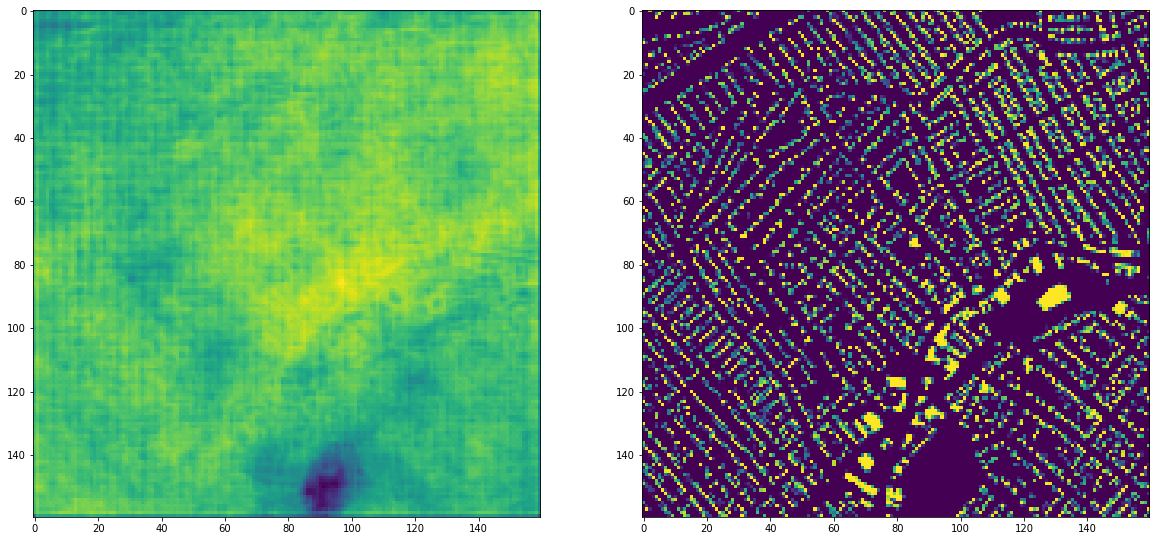

In [ ]:
f, axis = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(20)
axis[0].imshow(logits[0][1].detach())
axis[1].imshow(mask_tensor[0][0]);

#PytorchLightning classes

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

BATCH_SIZE = 2
LEARNING_RATE = 1e-5
EPOCHS = 20

date = datetime.datetime.today()
date = date.date()

In [ ]:
DATA_DIR = 'drive/MyDrive/Дипломный проект/datasets/mas-roofs/' # Massachusetts dataset
# DATA_DIR = 'data' # my dataset
# DATA_DIR = 'drive/MyDrive/Дипломный проект/datasets/aug_data/' # augmenteted Massachusetts dataset

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
class AutoModelBEiT(pl.LightningModule):

    def __init__(self, 
                 learning_rate: float = 1e-4,
                 ):
        
        super(AutoModelBEiT, self).__init__()
        self.model = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')

        # replace last layer of segformer
        # self.model.decode_head.classifier = nn.Conv2d(768, 2, kernel_size=(1, 1), stride=(1, 1))
        self.save_hyperparameters("learning_rate")


    def forward(self, x):
        outputs = self.model(**x)
        logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

        return logits


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        train_loss = F.cross_entropy(y_hat, y, reduction="mean")
        # print(train_loss, '-train')

        return train_loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        val_loss = F.cross_entropy(y_hat, y, reduction="mean")
        print(val_loss, '--valid')

        return val_loss


    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x for x in outputs]).mean()
        self.log('val_loss', avg_loss, prog_bar=True)
        
        return avg_loss 


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

        return optimizer

In [ ]:
class BEiTDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-finetuned-ade-640-640')
        # self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    
    def __getitem__(self, i):
        
        image = Image.open(self.image_paths[i]).convert('RGB')
        mask = Image.open(self.mask_paths[i]).convert('RGB')
        
        image = self.feature_extractor(images=image, return_tensors="pt")
        mask = self.feature_extractor(images=mask, return_tensors="pt")

        image["pixel_values"] = image["pixel_values"][0]
        mask["pixel_values"] = mask["pixel_values"][0]

        #reshaping mask
        transform = T.Resize((160,160))
        reshaped_mask = transform(mask['pixel_values'])

        true_mask = reshaped_mask > -1.0
        true_mask = torch.tensor(true_mask, dtype=torch.long) #long)
        # true_mask[true_mask == 0] == 94
        # true_mask[true_mask == 0] == 1
        return image, true_mask[0]
        
    def __len__(self):
        return len(self.image_paths)

In [ ]:
class BEiTDataModule(pl.LightningDataModule):
    def __init__(self, 
                 batch_size: int = 2):
        
        super().__init__()
        self.batch_size = batch_size

    def insert_data(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, drop_last=True)

# Train model

In [ ]:
train_dataset = BEiTDataset(
    x_train_dir, y_train_dir,
)

valid_dataset = BEiTDataset(
    x_valid_dir, y_valid_dir
)
data_loaders = BEiTDataModule(batch_size=BATCH_SIZE)
data_loaders.insert_data(train_dataset, valid_dataset)

In [ ]:
test_dataset = BEiTDataset(
    x_test_dir, y_test_dir
)

image, mask = test_dataset[0]

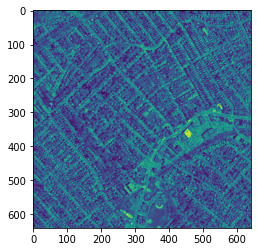

In [ ]:
plt.imshow(image['pixel_values'][0])

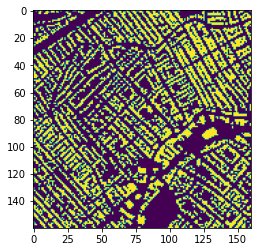

In [ ]:
plt.imshow(mask)

Find optimal learning rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(6.2054, device='cuda:0') --valid
tensor(5.9560, device='cuda:0') --valid


Finding best initial lr:   0%|          | 0/25 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_999688ff-b14d-4e9f-b978-bf0e7faa47bc.ckpt


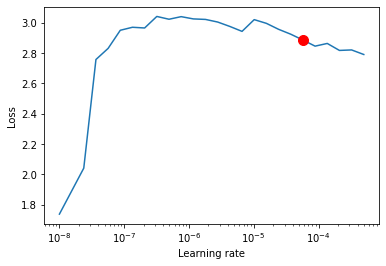

In [ ]:
# data_transforms = transforms.Compose([transforms.ToTensor()])
model = AutoModelBEiT(learning_rate=LEARNING_RATE)

trainer = pl.Trainer(
    gpus=-1,
    auto_lr_find=False,
    val_check_interval=0.5,
    log_every_n_steps=1,
    max_epochs=EPOCHS,
)

lr_finder = trainer.tuner.lr_find(model=model,
                                  datamodule=data_loaders,
                                  num_training=25,
                                  max_lr=5e-4)
fig = lr_finder.plot(suggest=True)
fig.show()

Training model

In [ ]:
model.hparams.learning_rate = lr_finder.suggestion()

trainer.fit(model, data_loaders)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                        | Params
------------------------------------------------------
0 | model | BeitForSemanticSegmentation | 163 M 
------------------------------------------------------
163 M     Trainable params
0         Non-trainable params
163 M     Total params
653.632   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

tensor(1380.5247, device='cuda:0') --valid
tensor(2000.6743, device='cuda:0') --valid


Training: 34it [00:00, ?it/s]

In [ ]:
trainer.save_checkpoint(f"beitmodel_{date}.ckpt")

In [ ]:
# !cp segmodel_2022-07-26.ckpt drive/MyDrive/'Дипломный проект'/'trained models'/segmodel_2022-07-26.ckpt
os.system(f'cp beitmodel_{date}.ckpt "drive/MyDrive/Дипломный проект/trained models/beitmodel_{date}.ckpt"')

0

# Test trained model

In [ ]:
model_ckpt_path = 'beitmodel_2022-07-28.ckpt'

if not os.path.exists(model_ckpt_path):
    model_ckpt_path = 'drive/MyDrive/Дипломный проект/trained models/beitmodel_2022-07-28.ckpt'

model = AutoModelSegFormer.load_from_checkpoint(model_ckpt_path)
feature_extractor = SegformerFeatureExtractor.from_pretrained("microsoft/beit-base-finetuned-ade-640-640")
model_name = model_ckpt_path.split('_')[0]
print(f'Loaded {model_name} model from this run.')

RuntimeError: ignored

In [ ]:
image = Image.open('mas_data/mas-roofs/test/22828990_15.png').convert('RGB')
mask = Image.open('mas_data/mas-roofs/test_labels/22828990_15.png').convert('RGB')

image = feature_extractor(images=image, return_tensors="pt", reduce_labels=True)
mask = feature_extractor(images=mask, return_tensors="pt")

#reshaping mask
transform = T.Resize((160,160))
reshaped_mask = transform(mask['pixel_values'])
# reshaped_mask = reshaped_mask[0][0]

true_mask = reshaped_mask > -1.0
true_mask = torch.tensor(true_mask, dtype=torch.long)
# print(true_mask[0], true_mask[1], true_mask[2])

In [ ]:
logits = model(image)
# pred_seg = transform_logits(logits)

In [ ]:
logits.argmax(dim=1)[0] # logits[batch][class*]; *class 1 == buildings, 94 == ground

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
logits_build = logits.argmax(dim=1)[0] == 1 
logits_build = torch.tensor(logits_build, dtype=torch.long)

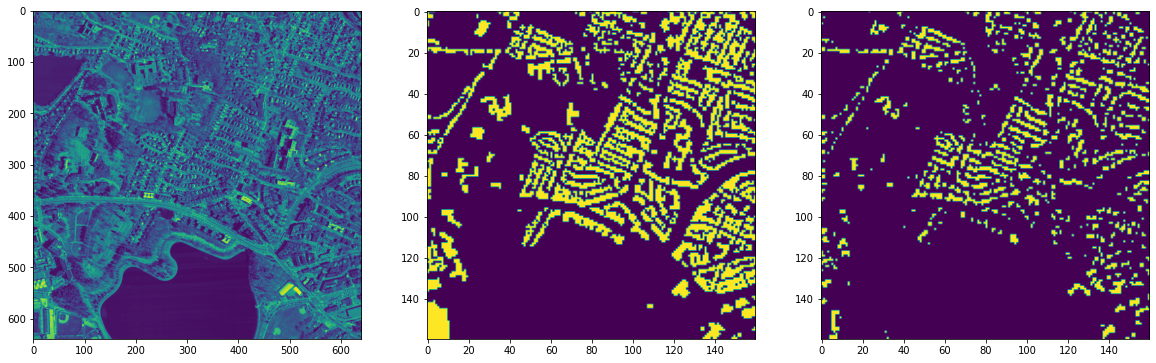

In [ ]:
f, axis = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(20)

axis[0].set_label('Input image')
axis[1].set_label('True mask')
axis[2].set_label('Predicted mask')

axis[0].imshow(image['pixel_values'][0][0].detach());
axis[1].imshow(true_mask[0][0].detach())
axis[2].imshow(logits_build.detach())